In [5]:
import sys
!{sys.executable} -m pip install eli5

In [30]:
#Importing required packages

import pandas as pd
import numpy as np
import psycopg2
from getpass import getpass
import matplotlib as plt
from sklearn.model_selection import train_test_split
import eli5
import seaborn as sns
import matplotlib.pyplot as plt
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [31]:
#Logging into the database with individual credentials
user = 'lixpm28'
db_ip = '10.158.72.23'
pw = getpass('Enter the database password for {}: '.format(user))

Enter the database password for lixpm28: ········


In [3]:
#Function definition to return temporal holdout sets using all features
def get_features( ref_day = 608-30, tumbling_window_size = 30, output_window_size = 30, num_periods = 7, window_agg_fun = 'SUM'):
        sql_top = """
        SELECT cust,
        %(ref_date)s AS ref_day,
        (CASE WHEN SUM(CASE WHEN dayofpurchase > %(ref_date)s AND dayofpurchase <= %(ref_date)s+%(ows)s THEN 1 ELSE 0 END)>0 THEN 1 ELSE 0 END) as output_feature,
        """
       
        sql=sql_top
#Creating temporal features to account for FREQUENCY of visits, QUANTITY of items, AMOUNT spent, GAP between consecutive visits
        for i in range(0,num_periods):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN 1 ELSE 0 END ) as freq{1},\n".format(i, i+1, window_agg_fun)
        for i in range(num_periods,num_periods*2):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN qty::INT ELSE 0 END ) as qty{1},\n".format(i, i+1, window_agg_fun)
        for i in range(num_periods*2,num_periods*3):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN val ELSE 0 END ) as amt{1},\n".format(i, i+1, window_agg_fun)
        for i in range(num_periods*3,num_periods*4):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN gap::INT ELSE 0 END ) as gap{1},\n".format(i, i+1, window_agg_fun)

        sql_bottom = """
        FROM temp_features
        GROUP BY cust
        """    
        sql = sql[:-2] + sql_bottom
        with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
            df = pd.read_sql(sql, conn, params = {'ref_date':ref_day,'ws':tumbling_window_size, 'ows':output_window_size})
            df=df.set_index('cust')
            return df.drop(columns = ['ref_day','output_feature'], inplace = False), df.output_feature

In [4]:
#Function to print variable importances
def print_variable_importances( feature_names, dict_in, show_top = 10 ):
  """
  Prints a table of feature importance scores.
  
  Keyword arguments
  feature_names -- list of feature names. Must have the same ordering as the 
                   scores in each instance of list_of_scores (see below)
  dict_in       -- dictionary of the form {method_name:list_of_scores} where:
                   method_name    -- string
                   list_of_scores -- list of scores, ordered in the same order
                                     as the passed feature_names
  show_top      -- number of features to show (default 10, None to print all)
  """


  # Implement the definition of None for show_top
  if show_top is None:
    show_top = len(feature_names)
  
  # Set up lists to hold the titles and score_feature tuples
  # We need a list so that they maintain fixed order as we 
  # iterate over them row-by-row.
  to_print_titles = []
  to_print_scores = []
  
  # Pair each list of scores with a copy of the feature names and sort
  # based on the variable importance score descending
  for k, v in dict_in.items():
    # zip pairs, sorted sorts, reverse orders descending
    feature_names_plus_scores = sorted( zip(v, feature_names) )
    feature_names_plus_scores.reverse()
    to_print_titles.append(k)
    to_print_scores.append(feature_names_plus_scores)
    
    
  # Print the scores
  
  # Create a list of strings to print in each header cell
  line_parts = []
  for j in range(len(to_print_titles)):
    line_parts.append('{:<38}'.format(to_print_titles[j]))
  
  # Print each header cell using a separator ' | ', adding the fixed rank column header 
  print('Rank | ' + ' | '.join( ['{:<38}'.format(x) for x in to_print_titles] ) )
  
  # Print the header underline
  print('---- + ' + ' + '.join( [ '-'*38 ]*len(to_print_titles) ) )
  
  # Print each line
  for i in range(show_top):
    # Create a list of strings to print for each row cell
    line_parts = []
    for j in range(len(to_print_titles)):
      line_parts.append(  '{:<30}: {:.4f}'.format(to_print_scores[j][i][1], to_print_scores[j][i][0]) )
    # Print the row by:
    # (1) joining each row cell using a separator ' | '
    # (2) adding the fixed rank column header 
    print( '{:<4} | '.format(str(i)) + ' | '.join(line_parts) )

In [5]:
#Splitting holdout set to evaluate feature importance
X, y = get_features(ref_day = 608-30, tumbling_window_size = 30, output_window_size = 30, num_periods = 7, window_agg_fun = 'SUM')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.columns

Index(['freq1', 'freq2', 'freq3', 'freq4', 'freq5', 'freq6', 'freq7', 'qty8',
       'qty9', 'qty10', 'qty11', 'qty12', 'qty13', 'qty14', 'amt15', 'amt16',
       'amt17', 'amt18', 'amt19', 'amt20', 'amt21', 'gap22', 'gap23', 'gap24',
       'gap25', 'gap26', 'gap27', 'gap28'],
      dtype='object')

In [6]:
#Calculating variable importances by permutation importance

#Splitting into training and test datasets
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

#Creating classifier model
rf_perm = RandomForestClassifier()

rf_perm.fit(X_train_sub, y_train_sub)

perm = PermutationImportance(rf_perm, cv='prefit')

perm.fit(X_test_sub, y_test_sub)


#Making predictions, calculating scores
y_pred = rf_perm.predict(X_test)
scores = accuracy_score(y_test, y_pred)

#Calculating and displaying feature importances

method_name = 'Perm non-cv RF ({:.2f})'.format(scores*100)

feature_importance_scores = {}
feature_importance_scores[method_name] = perm.feature_importances_
eli5.show_weights(perm)

print_variable_importances( X_train.columns, feature_importance_scores, show_top = None)

Rank | Perm non-cv RF (87.45)                
---- + --------------------------------------
0    | freq1                         : 0.0539
1    | freq3                         : 0.0502
2    | qty8                          : 0.0274
3    | amt16                         : 0.0272
4    | freq6                         : 0.0249
5    | freq2                         : 0.0240
6    | qty13                         : 0.0237
7    | qty12                         : 0.0237
8    | qty14                         : 0.0224
9    | qty11                         : 0.0222
10   | freq5                         : 0.0220
11   | qty10                         : 0.0213
12   | qty9                          : 0.0190
13   | freq7                         : 0.0185
14   | freq4                         : 0.0161
15   | amt15                         : 0.0156
16   | amt17                         : 0.0140
17   | amt19                         : 0.0100
18   | amt18                         : 0.0095
19   | amt20                      

In [7]:
#Function definition to return temporal holdout sets using just the selected features
def get_dataset( ref_day = 608-30, tumbling_window_size = 30, output_window_size = 30, num_periods = 7, window_agg_fun = 'SUM'):
        sql_top = """
        SELECT cust,
        %(ref_date)s AS ref_day,
        (CASE WHEN SUM(CASE WHEN dayofpurchase > %(ref_date)s AND dayofpurchase <= %(ref_date)s+%(ows)s THEN 1 ELSE 0 END)>0 THEN 1 ELSE 0 END) as output_feature,
        """
       
        sql=sql_top
#Creating temporal features to account for FREQUENCY of visits, QUANTITY of items, AMOUNT spent
        for i in range(0,num_periods):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN 1 ELSE 0 END ) as freq{1},\n".format(i, i+1, window_agg_fun)
        for i in range(num_periods,num_periods*2):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN qty::INT ELSE 0 END ) as qty{1},\n".format(i, i+1, window_agg_fun)
        for i in range(num_periods*2,num_periods*3):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN val ELSE 0 END ) as amt{1},\n".format(i, i+1, window_agg_fun)

        sql_bottom = """
        FROM temp_features
        GROUP BY cust
        """    
        sql = sql[:-2] + sql_bottom
        with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
            df = pd.read_sql(sql, conn, params = {'ref_date':ref_day,'ws':tumbling_window_size, 'ows':output_window_size})
            df=df.set_index('cust')
            return df.drop(columns = ['ref_day','output_feature'], inplace = False), df.output_feature

In [8]:
#Training and assessment of classifier models

output_window_size = 30 
tumbling_window_size = 30
total_holdout_sets = 7
now =  608-output_window_size

modelrf = RandomForestClassifier(n_estimators=100, max_depth=20)
modelknn = KNeighborsClassifier(n_neighbors=3, weights='uniform')
modelsvc = LinearSVC()

#Creating empty lists to store accuracy scores across holdout sets
accrf = []
balrf = []
recrf = []
specrf = []
precrf = []

accknn = []
balknn = []
recknn = []
specknn = []
precknn = []

accsvc = []
balsvc = []
recsvc = []
specsvc = []
precsvc = []

#Iterations through holdout sets
for i in range(total_holdout_sets):
    test_X, test_y = get_dataset( now - output_window_size, tumbling_window_size, output_window_size )
    test_X=test_X[test_X.freq1>0]
    indices1=list(test_X[test_X.freq1>0].index.values)
    test_y=test_y[test_y.index.isin(indices1)]
    
    train_X, train_y = get_dataset( now - 2*output_window_size, tumbling_window_size, output_window_size )
    train_X=train_X[train_X.freq1>0]
    indices1=list(train_X[train_X.freq1>0].index.values)
    train_y=train_y[train_y.index.isin(indices1)]
    
    #Fitting the Random Forest classifier Model and making predictions with it
    modelrf.fit( train_X, train_y )
    preds_rf = modelrf.predict(test_X)
    
    #Fitting the KNN classifier Model and making predictions with it
    modelknn.fit( train_X, train_y )
    preds_knn = modelknn.predict(test_X)
    
    #Fitting the SVC Model and making predictions with it
    modelsvc.fit( train_X, train_y )
    preds_svc = modelsvc.predict(test_X)
    
    #Calculating metric scores for Random Forest model
    accuracyrf = accuracy_score(test_y,preds_rf)
    balancedrf = balanced_accuracy_score(test_y,preds_rf)
    recallrf = recall_score(test_y,preds_rf)
    specificityrf = recall_score(test_y,preds_rf, pos_label = 0)
    precisionrf = precision_score(test_y, preds_rf)
    
    #Appending Random Forest model scores to list
    accrf.append(accuracyrf)
    balrf.append(balancedrf)
    precrf.append(precisionrf)
    recrf.append(recallrf)
    specrf.append(specificityrf)
    
    #Calculating metric scores for KNN classifier model
    accuracyknn = accuracy_score(test_y,preds_knn)
    balancedknn = balanced_accuracy_score(test_y,preds_knn)
    recallknn = recall_score(test_y,preds_knn)
    specificityknn = recall_score(test_y,preds_knn, pos_label = 0)
    precisionknn = precision_score(test_y, preds_knn)
    
    #Appending KNN scores to list
    accknn.append(accuracyknn)
    balknn.append(balancedknn)
    precknn.append(precisionknn)
    recknn.append(recallknn)
    specknn.append(specificityknn)
    
    #Calculating metric scores for SVC model
    accuracysvc = accuracy_score(test_y,preds_svc)
    balancedsvc = balanced_accuracy_score(test_y,preds_svc)
    recallsvc = recall_score(test_y,preds_svc)
    specificitysvc = recall_score(test_y,preds_svc, pos_label = 0)
    precisionsvc = precision_score(test_y, preds_svc)
    
    #Appending SVC scores to list
    accsvc.append(accuracysvc)
    balsvc.append(balancedsvc)
    precsvc.append(precisionsvc)
    recsvc.append(recallsvc)
    specsvc.append(specificitysvc)
    
    #For next holdout
    now = now - output_window_size
print('For Random Forest Classifiers ~ Acc. {} Recall: {} Specificity: {} Balanced: {} Precision: {}'.format(np.mean(accrf),np.mean(recrf),np.mean(specrf),np.mean(balrf),np.mean(precrf)))
print('For KNN Classifiers ~ Acc. {} Recall: {} Specificity: {} Balanced: {} Precision: {}'.format(np.mean(accknn),np.mean(recknn),np.mean(specknn),np.mean(balknn),np.mean(precknn)))
print('For Linear SVC ~ Acc. {} Recall: {} Specificity: {} Balanced: {} Precision: {}'.format(np.mean(accsvc),np.mean(recsvc),np.mean(specsvc),np.mean(balsvc),np.mean(precsvc)))

/home/lixpm28/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/lixpm28/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/lixpm28/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/lixpm28/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/lixpm28/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

For Random Forest Classifiers ~ Acc. 0.7754410172806832 Recall: 0.8500225305418899 Specificity: 0.6523549303088922 Balanced: 0.7511887304253911 Precision: 0.8027067875808288
For KNN Classifiers ~ Acc. 0.7338714285833624 Recall: 0.784603950769486 Specificity: 0.650475517892508 Balanced: 0.717539734330997 Precision: 0.7886680818695736
For Linear SVC ~ Acc. 0.7457635323633144 Recall: 0.7349973321119975 Specificity: 0.767766017163513 Balanced: 0.7513816746377552 Precision: 0.8436390048231696


/home/lixpm28/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [9]:
#Since Random Forest Classifier was my best performing model
#Testing on unseen test holdout dataset

output_window_size = 30 
tumbling_window_size = 30
now =  608

#Create an estimator of the winning model
model = RandomForestClassifier(n_estimators = 100, max_depth=20)

#Creating test dataset
test_X, test_y = get_dataset( now - output_window_size, tumbling_window_size, output_window_size )

test_X=test_X[test_X.freq1>0]
indices1=list(test_X[test_X.freq1>0].index.values)
test_y=test_y[test_y.index.isin(indices1)]

#Creating training dataset
train_X, train_y = get_dataset( now - 2*output_window_size, tumbling_window_size, output_window_size )

train_X=train_X[train_X.freq1>0]
indices1=list(train_X[train_X.freq1>0].index.values)
train_y=train_y[train_y.index.isin(indices1)]

model.fit( train_X, train_y )
preds = pd.DataFrame(model.predict(test_X), columns=['Output'], index=test_X.index.values)

#Calculating metric scores for Random Forest model
accuracy = accuracy_score(test_y,preds)
balanced = balanced_accuracy_score(test_y,preds)
recall = recall_score(test_y,preds)
specificity = recall_score(test_y,preds, pos_label = 0)
precision = precision_score(test_y, preds)

print('For Random Forest Classifiers ~ Acc. {} Recall: {} Specificity: {} Balanced: {} Precision: {}'.format(accuracy,recall,specificity,balanced,precision))

For Random Forest Classifiers ~ Acc. 0.7714723926380368 Recall: 0.8608374384236454 Specificity: 0.6239837398373984 Balanced: 0.7424105891305219 Precision: 0.7907239819004525


In [10]:
test_y.value_counts()

1    812
0    492
Name: output_feature, dtype: int64

In [11]:
np.unique(preds, return_counts=True)

(array([0, 1]), array([420, 884]))

In [12]:
preds['Output'].value_counts()

1    884
0    420
Name: Output, dtype: int64

In [13]:
#Displaying characteristics of customers predicted to stay active
pd.options.display.max_columns = None
indices_active_preds=list(preds[preds['Output']==1].index.values)
test_X[test_X.index.isin(indices_active_preds)].describe()

,freq1,freq2,freq3,freq4,freq5,freq6,freq7,qty8,qty9,qty10,qty11,qty12,qty13,qty14,amt15,amt16,amt17,amt18,amt19,amt20,amt21
count,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.0
mean,3.291855,3.033937,3.007919,2.839367,2.828054,2.952489,2.875566,33.803167,33.240950,33.826923,32.546380,32.121041,33.994344,32.964932,40.405588,42.115588,33.076527,33.240385,31.044977,7.856505,0.0
std,2.928112,3.146297,3.279875,3.153525,3.000163,3.270376,3.231763,47.207762,48.741694,48.828130,46.955041,46.970582,47.237394,46.070087,51.389362,52.983199,51.924402,55.674863,51.702204,19.108847,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,17.000000,17.000000,17.000000,15.000000,15.500000,17.000000,18.000000,23.070000,25.375000,12.750000,0.000000,0.000000,0.000000,0.0
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,45.000000,44.000000,45.250000,42.000000,45.000000,46.000000,45.000000,58.012500,62.035000,45.860000,48.845000,47.432500,8.385000,0.0
max,27.000000,25.000000,25.000000,23.000000,23.000000,27.000000,26.000000,318.000000,512.000000,463.000000,413.000000,421.000000,373.000000,349.000000,310.040000,404.820000,485.720000,434.130000,389.680000,289.110000,0.0


In [14]:
#Displaying characteristics of customers predicted to churn
pd.options.display.max_columns = None
indices_churn_preds=list(preds[preds['Output']==0].index.values)
test_X[test_X.index.isin(indices_churn_preds)].describe()

,freq1,freq2,freq3,freq4,freq5,freq6,freq7,qty8,qty9,qty10,qty11,qty12,qty13,qty14,amt15,amt16,amt17,amt18,amt19,amt20,amt21
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.0
mean,1.135714,0.269048,0.211905,0.204762,0.207143,0.121429,0.188095,1.935714,2.411905,2.259524,2.435714,2.435714,1.885714,2.845238,3.062429,2.645595,1.784881,1.418143,0.994762,0.332524,0.0
std,0.771299,0.599518,0.561579,0.474632,0.486031,0.348221,0.458649,6.033966,7.015792,7.709943,8.230171,6.549475,6.707762,9.549387,11.999898,8.477545,7.614256,6.917893,5.163256,2.899398,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,15.000000,5.000000,5.000000,3.000000,3.000000,2.000000,3.000000,57.000000,50.000000,73.000000,66.000000,61.000000,55.000000,76.000000,131.140000,66.540000,93.580000,71.810000,47.490000,46.900000,0.0


In [15]:
#Displaying characteristics of customers that stay active in reality
pd.options.display.max_columns = None
indices_active_actual=list(test_y[test_y==1].index.values)
test_X[test_X.index.isin(indices_active_actual)].describe()

,freq1,freq2,freq3,freq4,freq5,freq6,freq7,qty8,qty9,qty10,qty11,qty12,qty13,qty14,amt15,amt16,amt17,amt18,amt19,amt20,amt21
count,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.0
mean,3.376847,3.098522,3.099754,2.899015,2.846059,2.961823,2.908867,34.408867,34.178571,34.112069,33.433498,32.815271,33.740148,32.891626,40.237672,41.909015,32.774347,33.869224,31.528116,8.090739,0.0
std,3.041571,3.257187,3.363128,3.240412,3.088852,3.344174,3.319274,48.468306,49.667366,49.920884,47.760518,47.918759,48.404509,47.354221,52.641999,53.548029,52.657013,56.104911,52.848800,19.571244,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,17.000000,18.000000,16.000000,15.000000,16.000000,15.500000,16.000000,21.190000,24.470000,11.265000,0.000000,0.000000,0.000000,0.0
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,47.000000,45.250000,47.000000,44.250000,45.000000,46.000000,46.000000,58.965000,62.300000,45.582500,51.155000,48.567500,8.457500,0.0
max,27.000000,25.000000,25.000000,23.000000,23.000000,27.000000,26.000000,318.000000,512.000000,463.000000,413.000000,421.000000,373.000000,349.000000,310.040000,404.820000,485.720000,434.130000,389.680000,289.110000,0.0


In [16]:
#Displaying characteristics of customers that churn in reality
pd.options.display.max_columns = None
indices_churn_actual=list(test_y[test_y==0].index.values)
test_X[test_X.index.isin(indices_churn_actual)].describe()

,freq1,freq2,freq3,freq4,freq5,freq6,freq7,qty8,qty9,qty10,qty11,qty12,qty13,qty14,amt15,amt16,amt17,amt18,amt19,amt20,amt21
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,1.310976,0.567073,0.469512,0.491870,0.560976,0.520325,0.526423,5.599593,5.376016,6.408537,5.378049,5.634146,7.004065,7.373984,8.804411,8.762622,6.862866,5.037215,4.594980,1.047012,0.0
std,0.824054,1.009917,1.072279,1.068878,1.163927,1.339359,1.187731,15.155146,16.535553,17.918626,17.021233,16.171821,18.249571,17.625846,22.068995,24.319562,21.613769,22.011503,16.963263,5.748623,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,5.000000,2.250000,3.000000,4.000000,5.000000,6.455000,4.640000,0.000000,0.000000,0.000000,0.000000,0.0
max,9.000000,8.000000,13.000000,14.000000,13.000000,19.000000,14.000000,176.000000,232.000000,235.000000,261.000000,188.000000,195.000000,163.000000,177.910000,226.630000,225.530000,341.730000,176.260000,68.810000,0.0


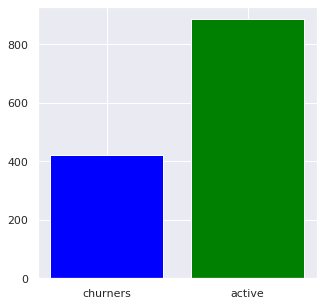

In [17]:
#Churners v Active count
sns.set()
plt.rcParams['figure.figsize'] = (5.0, 5.0)
labels = ['churners','active']
values = [len(preds[preds['Output']==0]), len(preds[preds['Output']==1])]
plt.bar([0, 1], values, align='center', color=['blue', 'green'])
plt.xticks([0, 1], labels)
plt.show()

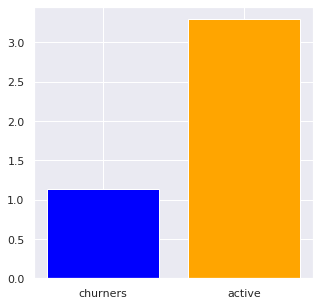

In [18]:
#Comparison based on frequency of store visits
x=test_X[test_X.index.isin(indices_active_preds)]
y=test_X[test_X.index.isin(indices_churn_preds)]
Freq_mean=[y['freq1'].mean(),x['freq1'].mean()]
sns.set()
plt.rcParams['figure.figsize'] = (5.0, 5.0)
labels = ['churners','active']
values = Freq_mean
plt.bar([0, 1], values, align='center', color=['blue', 'orange'])
plt.xticks([0, 1], labels)
plt.show()

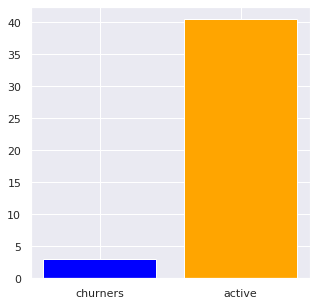

In [19]:
#Comparison based on average spend
x=test_X[test_X.index.isin(indices_active_preds)]
y=test_X[test_X.index.isin(indices_churn_preds)]
Freq_mean=[y['amt15'].mean(),x['amt15'].mean()]
sns.set()
plt.rcParams['figure.figsize'] = (5.0, 5.0)
labels = ['churners','active']
values = Freq_mean
plt.bar([0, 1], values, align='center', color=['blue', 'orange'])
plt.xticks([0, 1], labels)
plt.show()

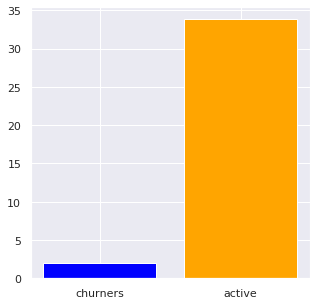

In [20]:
#Comparison based on average quantities purchased
x=test_X[test_X.index.isin(indices_active_preds)]
y=test_X[test_X.index.isin(indices_churn_preds)]
Freq_mean=[y['qty8'].mean(),x['qty8'].mean()]
sns.set()
plt.rcParams['figure.figsize'] = (5.0, 5.0)
labels = ['churners','active']
values = Freq_mean
plt.bar([0, 1], values, align='center', color=['blue', 'orange'])
plt.xticks([0, 1], labels)
plt.show()

In [32]:
#Function definition to return test holdout
def get_testholdout( ref_day = 608-30, tumbling_window_size = 30, num_periods = 7, window_agg_fun = 'SUM'):
        sql_top = """
        SELECT cust,
        %(ref_date)s AS ref_day,
        """
       
        sql=sql_top
#Creating temporal features to account for FREQUENCY of visits, QUANTITY of items, AMOUNT spent
        for i in range(0,num_periods):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN 1 ELSE 0 END ) as freq{1},\n".format(i, i+1, window_agg_fun)
        for i in range(num_periods,num_periods*2):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN qty::INT ELSE 0 END ) as qty{1},\n".format(i, i+1, window_agg_fun)
        for i in range(num_periods*2,num_periods*3):
            sql += "{2}(CASE WHEN dayofpurchase > %(ref_date)s -%(ws)s::INT*({0}+1) AND dayofpurchase <= %(ref_date)s-%(ws)s*({0}) THEN val ELSE 0 END ) as amt{1},\n".format(i, i+1, window_agg_fun)

        sql_bottom = """
        FROM temp_features
        GROUP BY cust
        """    
        sql = sql[:-2] + sql_bottom
        with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
            df = pd.read_sql(sql, conn, params = {'ref_date':ref_day,'ws':tumbling_window_size})
            df=df.set_index('cust')
            return df.drop(columns = ['ref_day'], inplace = False)

In [33]:
#Final Predictor Model
#Function definition that returns the predictions when called
#Since Random Forest Classifiers were my best performing model

def predictions(ref_day = 608, tumbling_window_size = 30, output_window_size = 7):

#Create an estimator of the winning model
    model = RandomForestClassifier(n_estimators = 100, max_depth=20)

#Creating training dataset
    train_X, train_y = get_dataset( ref_day - 2*output_window_size, tumbling_window_size, output_window_size )
    train_X=train_X[train_X.freq1>0]
    indices1=list(train_X[train_X.freq1>0].index.values)
    train_y=train_y[train_y.index.isin(indices1)]

    model.fit( train_X, train_y )
    test_X = get_testholdout( ref_day - output_window_size, tumbling_window_size)

    test_X=test_X[test_X.freq1>0]
#Final predictions
    preds = pd.DataFrame(model.predict(test_X), columns=['Output'], index=test_X.index.values)
    return preds

In [34]:
#Set ref_day to the day of prediction before executing
df=predictions(ref_day = 608, tumbling_window_size = 30, output_window_size = 7)

In [29]:
#Returning set of predictions for the active customers
df

,Output
39,0
47,0
55,1
76,1
86,0
...,...
16213,1
16221,0
16263,1
16273,0
